In [1]:
import os
import json

# Load annotations
annotations = []
base_dir = "E:/Om/Other Projects/ClearQuote_Assignment/data"  # Replace with your actual path
for root, _, files in os.walk(base_dir):
    for file in files:
        if file == "via_region_data.json":
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
                for key, annotation in data.items():  # Assuming VIA annotations are stored in a dictionary
                    annotation["path"] = os.path.relpath(root, base_dir)
                annotations.extend(data.values())  # Assuming VIA annotations are stored in a dictionary

In [2]:
annotation_to_class = {
    "Front": [
        "bonnet", "frontbumper", "frontws", "headlightwasher", "indicator",
        "leftheadlamp", "rightheadlamp", "frontbumpergrille", "lowerbumpergrille",
        "licenseplate", "namebadge"
    ],
    "Rear": [
        "rearbumper", "rearws", "fuelcap", "taillamp", "rearbumpercladding",
        "leftbootlamp", "rightbootlamp", "towbarcover", "lefttailgate",
        "righttailgate", "rearbumpermissing", "rearwsmissing"
    ],
    "Front-Right": [
        "rightfender", "rightfrontdoor", "rightfrontdoorglass", "rightorvm",
        "rightfoglamp", "partial_rightfender", "partial_rightfrontdoor",
        "rightfrontbumper"
    ],
    "Front-Left": [
        "leftfender", "leftfrontdoor", "leftfrontdoorglass", "leftorvm",
        "leftfoglamp", "partial_leftfender", "partial_leftfrontdoor",
        "leftfrontbumper"
    ],
    "Rear-Right": [
        "rightqpanel", "rightreardoor", "rightreardoorglass", "rightrearventglass",
        "partial_rightqpanel", "partial_rightreardoor", "rightrearbumper"
    ],
    "Rear-Left": [
        "leftqpanel", "leftreardoor", "leftreardoorglass", "leftrearventglass",
        "partial_leftqpanel", "partial_leftreardoor", "leftrearbumper"
    ],
    "None": [
        "alloywheel", "antenna", "car", "cracked", "dirt", "logo", "reflection",
        "rust", "scratch", "shattered", "sensor", "sunroof", "wiper", "series"
    ]
}


In [ ]:
import pandas as pd

# Example: Suppose you have a dictionary that maps string annotations to classes
# You can change or expand this based on your data
annotation_to_class = {
    "Front-Left": ["leftrunningboard", "leftfrontdoor", "doorhandlefrontleftdoor"],
    "Rear-Left": ["leftreardoor", "doorhandleleftreardoor"],
    "Front": ["frontbumper", "frontgrill"],
    "Rear": ["rearbumper", "reartrunk"],
    # etc.
}

# Example annotations structure (list of dicts). 
# In real usage, you will have your own `annotations` list with the same structure.
annotations = [
    {
        'filename': 'scraped_5eNgaP_1626956023618.jpg',
        'path': '6124bc827eb77b4a469ef1c0',
        'regions': [
            {
                'shape_attributes': {
                    'name': 'polygon',
                    'all_points_x': [0, 100, 100, 0],
                    'all_points_y': [0, 0, 50, 50]
                },
                'region_attributes': {'identity': 'leftrunningboard'}
            },
            {
                'shape_attributes': {
                    'name': 'polygon',
                    'all_points_x': [110, 140, 140, 110],
                    'all_points_y': [0, 0, 60, 60]
                },
                'region_attributes': {'identity': 'leftfrontdoor'}
            },
            # Add as many regions as needed...
        ]
    },
    {
        'filename': 'scraped_xlEWWq_1597927388356.jpg',
        'path': '5f3e735459dc8c3bea8c485f',
        'regions': [
            {
                'shape_attributes': {
                    'name': 'polygon',
                    'all_points_x': [10, 60, 60, 10],
                    'all_points_y': [10, 10, 70, 70]
                },
                'region_attributes': {'identity': 'unknownsomepart'}
            },
            {
                'shape_attributes': {
                    'name': 'polygon',
                    'all_points_x': [70, 120, 120, 70],
                    'all_points_y': [10, 10, 80, 80]
                },
                'region_attributes': {'identity': 'doorhandle'}  # Not in annotation_to_class => 'None'
            },
            # ...
        ]
    },
    # ...
]

# Initialize the result list
image_data = []

#########################################################
# THRESHOLD_FACTOR: how many times bigger "None" must be
# than any other label to be chosen as the final label.
#########################################################
THRESHOLD_FACTOR = 2.0  

for annotation in annotations:
    file_name = annotation['filename']
    regions = annotation.get('regions', [])
    
    annotation_list = []
    annotation_areas = []
    class_labels = []
    class_areas = []
    
    # Initialize the label area map with every known class + 'None' to 0
    label_area_map = {label: 0 for label in annotation_to_class.keys()}
    label_area_map['None'] = 0

    # --- Process each region ---
    for region in regions:
        shape_attributes = region['shape_attributes']
        region_attributes = region['region_attributes']

        # Extract the annotation name from 'identity'
        annotation_name = region_attributes.get('identity', 'None')

        # Determine which class label it belongs to (if any)
        label = next(
            (key for key, values in annotation_to_class.items() 
             if annotation_name in values),
            'None'
        )

        # Calculate the area of the annotation
        if shape_attributes.get('name') == 'polygon':
            x = shape_attributes['all_points_x']
            y = shape_attributes['all_points_y']
            area = 0.5 * abs(sum(x[i] * y[i+1] - x[i+1] * y[i] 
                                 for i in range(-1, len(x)-1)))
        else:
            # In case of other shapes, set area to 0 or handle differently
            area = 0

        # Append the raw annotation data
        annotation_list.append(annotation_name)
        annotation_areas.append(area)

        # If we haven't seen this class label yet, initialize; otherwise add to it
        if label not in class_labels:
            class_labels.append(label)
            class_areas.append(area)
        else:
            class_areas[class_labels.index(label)] += area

        # Update the total area for this label
        label_area_map[label] += area

    # --- Determine the final label --- 
    if not annotation_list:
        # If there are NO annotations at all, final_label = 'None'
        final_label = 'None'
    else:
        # Separate 'None' area from other labels' areas
        none_area = label_area_map.get('None', 0)
        # Dictionary with everything except 'None'
        label_area_map_no_none = {
            k: v for k, v in label_area_map.items() if k != 'None'
        }

        if not label_area_map_no_none:
            # If the only label is 'None', final_label = 'None'
            final_label = 'None'
        else:
            # Find the label with the largest area among non-'None'
            max_non_none_label = max(label_area_map_no_none, key=label_area_map_no_none.get)
            max_non_none_area = label_area_map_no_none[max_non_none_label]

            # Compare 'None' area vs. largest non-'None' area
            if none_area > THRESHOLD_FACTOR * max_non_none_area:
                final_label = 'None'
            else:
                final_label = max_non_none_label
    
    # Optional: print debug info
    print(f"label_area_map: {label_area_map} -> final_label: {final_label}")

    # --- Append data to the result list ---
    image_data.append({
        "path": annotation["path"],
        'image': file_name,
        'annotations': annotation_list,
        'ann_areas': annotation_areas,
        'class_labels': class_labels,
        'class_areas': class_areas,
        'final_label': final_label
    })

# Convert to DataFrame
df = pd.DataFrame(image_data)
print("\nFinal DataFrame:")
print(df)


In [18]:
# import pandas as pd

# # Initialize the result list
# image_data = []

# # Define a high threshold multiplier for the "None" label
# none_threshold_multiplier = 2.5  # Adjust this value as needed

# for annotation in annotations:
#     file_name = annotation['filename']
#     regions = annotation.get('regions', [])
    
#     annotation_list = []
#     annotation_areas = []
#     class_labels = []
#     class_areas = []
#     label_area_map = {label: 0 for label in annotation_to_class.keys()}  # Map to accumulate area by label

#     for region in regions:
#         shape_attributes = region['shape_attributes']
#         region_attributes = region['region_attributes']

#         # Extract the annotation name and corresponding label
#         annotation_name = region_attributes.get('identity', 'None')
#         label = next(
#             (key for key, values in annotation_to_class.items() if annotation_name in values),
#             'None'
#         )

#         # Calculate the area of the annotation
#         if shape_attributes.get('name') == 'polygon':
#             x = shape_attributes['all_points_x']
#             y = shape_attributes['all_points_y']
#             area = 0.5 * abs(sum(x[i] * y[i+1] - x[i+1] * y[i] for i in range(-1, len(x)-1)))
#         else:
#             area = 0  # Handle other shapes (e.g., rectangles) if needed

#         # Append annotation data
#         annotation_list.append(annotation_name)
#         annotation_areas.append(area)

#         # Append class label data
#         if label not in class_labels:
#             class_labels.append(label)
#             class_areas.append(area)
#         else:
#             # Add area to the existing class label
#             class_areas[class_labels.index(label)] += area

#         # Update label area map
#         label_area_map[label] += area

#     # Determine the final label with the largest area
#     final_label = max(label_area_map, key=label_area_map.get)
#     largest_area = label_area_map[final_label]
#     none_area = label_area_map.get("None", 0)

#     # Apply the higher threshold for "None"
#     if none_area > 0 and none_area > none_threshold_multiplier * largest_area:
#         final_label = "None"
#     elif annotation_list == [] or all(area == 0 for area in label_area_map.values()):
#         final_label = "None"

#     # Append the data to the result list
#     image_data.append({
#         "path": annotation["path"],
#         'image': file_name,
#         'annotations': annotation_list,
#         'ann_areas': annotation_areas,
#         'class_labels': class_labels,
#         'class_areas': class_areas,
#         'final_label': final_label
#     })

# # Convert the result list into a DataFrame
# df = pd.DataFrame(image_data)

# Save the DataFrame to a CSV file
# Add a new column for multi-class labels
def calculate_multi_class_labels(row, threshold=0.1):
    if row["class_areas"] == []:
        return ['None']
    largest_area = max(row["class_areas"])
    multi_class_labels = [
        label for label, area in zip(row["class_labels"], row["class_areas"])
        if area >= threshold * largest_area
    ]
    return multi_class_labels

df["multi_class_labels"] = df.apply(calculate_multi_class_labels, axis=1)
df.head()


,path,image,annotations,ann_areas,class_labels,class_areas,final_label,multi_class_labels
0,5e9112c35026365e15eb871b,IMG_20200219_170506_1586530497634.jpeg,"[frontws, wiper, rightapillar, wiper, partial_...","[258547.0, 11870.0, 13326.5, 8029.0, 150500.5,...","[Front, None]","[258547.0, 210635.5]",Front,"[Front, None]"
1,5e9112c35026365e15eb871b,IMG_20200219_170530_1586530511170_blurred.jpeg,"[frontws, leftorvm, wiper, leftapillar, wiper,...","[266412.5, 22249.0, 14518.5, 20825.5, 4460.5, ...","[Front, Front-Left, None]","[266412.5, 48386.0, 159221.0]",Front,"[Front, Front-Left, None]"
2,5e9112c35026365e15eb871b,IMG_20200219_170547_1586530520210_blurred.jpeg,"[tailgate, lefttaillamp, logo, righttaillamp, ...","[224137.0, 33581.5, 4739.5, 22429.5, 4486.5, 4...","[None, Front]","[564960.5, 4486.5]",None,[None]
3,5e9112c35026365e15eb871b,IMG_20200219_170542_1586530514683_blurred.jpeg,"[lefttaillamp, leftqpanel, tailgate, leftreard...","[52050.5, 77116.0, 62021.0, 107876.5, 15105.0,...","[None, Rear-Left, Rear, Front]","[193024.5, 207912.0, 105744.5, 2860.0]",Rear-Left,"[None, Rear-Left, Rear]"
4,5e9112c35026365e15eb871b,IMG_20200219_170520_1586530505664.jpeg,"[leftheadlamp, towbarcover, partial_frontbumpe...","[139279.5, 2516.0, 195507.5, 169301.0, 35557.5...","[Front, Rear, None, Front-Left]","[139279.5, 2516.0, 350022.5, 169301.0]",None,"[Front, None, Front-Left]"


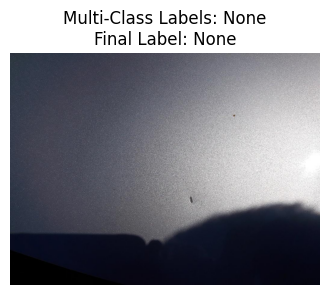

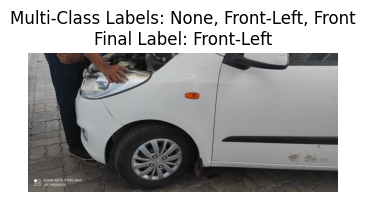

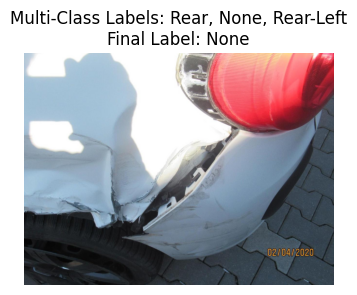

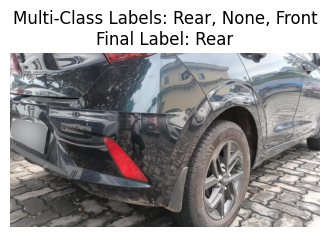

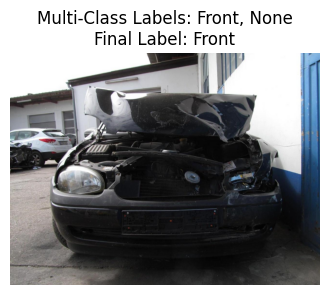

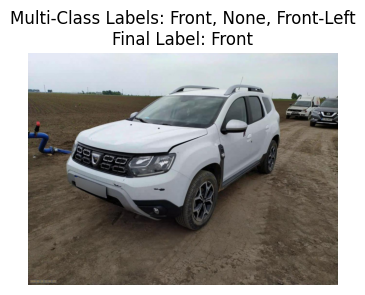

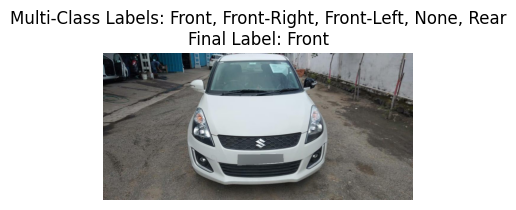

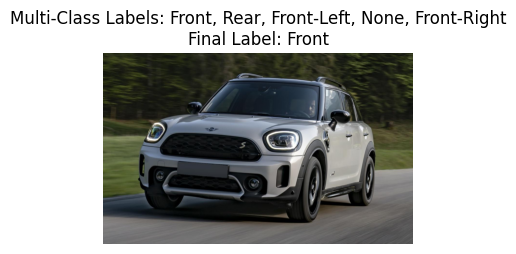

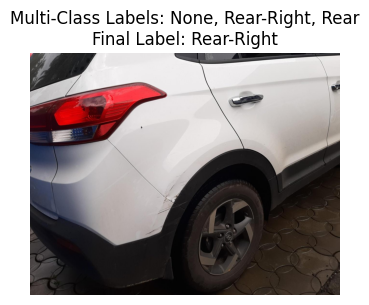

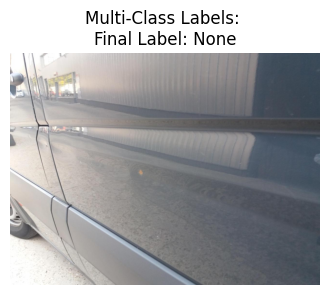

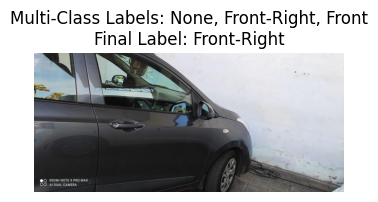

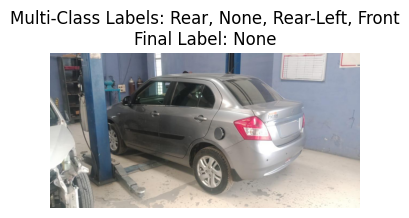

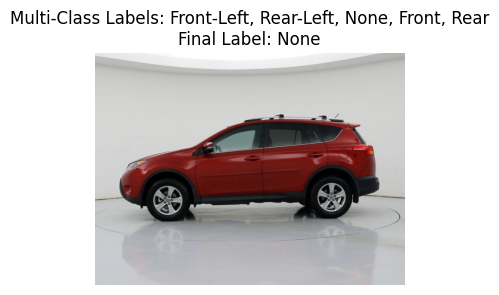

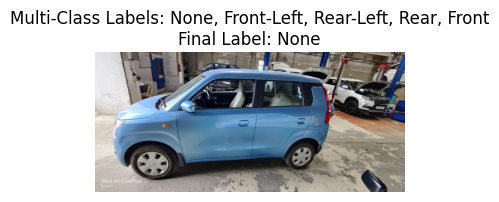

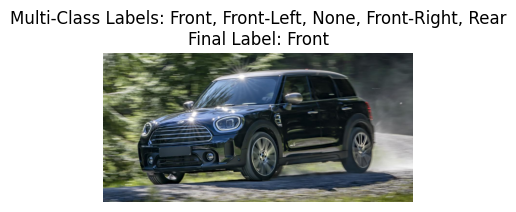

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

sampled_df = df.sample(n=15, random_state=40)

# Plot images with multi-class labels and final labels
for index, row in sampled_df.iterrows():
    image_path = f"{base_dir}/{row['path']}/{row['image']}"
    try:
        # Load image
        img = Image.open(image_path)
        
        # Plot image
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Multi-Class Labels: {', '.join(row['class_labels'])}\nFinal Label: {row['final_label']}")
        plt.show()
    except FileNotFoundError:
        print(f"Image not found: {image_path}")


In [20]:
sampled_df

,path,image,annotations,ann_areas,class_labels,class_areas,final_label,multi_class_labels
1506,6090de01cb62764ca53766bb,scraped_1CzEqg_1620086043688.jpg,[scratch],[2569.0],[None],[2569.0],None,[None]
1421,6070519abaef3f56aa24cf3a,scraped_Nos1Qv_1617828758529.jpg,"[tyre, leftfender, indicator, frontbumper, whe...","[72196.0, 110992.0, 1856.0, 30564.0, 28055.5, ...","[None, Front-Left, Front]","[124418.5, 314170.0, 32420.0]",Front-Left,"[None, Front-Left, Front]"
1688,60d40582cb62764ca5387ab4,scraped_hNK51Z_1624306694449.jpg,"[rearbumper, tyre, d3, scratch, leftqpanel, le...","[201730.0, 120791.5, 328237.5, 112797.5, 44694...","[Rear, None, Rear-Left]","[201730.0, 763670.0, 446942.0]",None,"[Rear, None, Rear-Left]"
1028,6024c8bf5b913441612636e2,scraped_63Suql_1612876806543.jpg,"[rearbumper, tyre, alloywheel, licenseplate, s...","[349221.0, 96435.5, 38914.0, 13471.5, 1155.0, ...","[Rear, None, Front]","[349221.0, 149827.0, 13471.5]",Rear,"[Rear, None]"
1702,60d40582cb62764ca5387ab4,scraped_gOxKY8_1624382419035.jpg,"[frontbumper, rightheadlamp, bonnet, d3, d2, s...","[219262.5, 18676.0, 111046.5, 104670.5, 6641.5...","[Front, None]","[404083.5, 143317.0]",Front,"[Front, None]"
2573,617101a0d45ab471674827d3,scraped_9zVSHD_1634754795341.jpg,"[bonnet, leftheadlamp, frontws, frontbumpergri...","[48113.0, 14724.5, 37344.5, 21376.0, 5509.0, 1...","[Front, None, Front-Left]","[196550.0, 97569.0, 63310.5]",Front,"[Front, None, Front-Left]"
2469,6128ba757eb77b4a469ef522,scraped_ePyqHO_1627291221779.jpg,"[frontbumper, lowerbumpergrille, frontws, righ...","[66515.46999999993, 10512.610000000015, 31092....","[Front, Front-Right, Front-Left, None, Rear]","[181953.23999999996, 3949.6099999999715, 3271....",Front,[Front]
3109,625e744cb098d00d5a42a07b,scraped_z4xRrp_1649427869967.jpg,"[frontbumpergrille, frontws, frontbumper, lice...","[37479.5, 59024.5, 117293.5, 10543.0, 15863.5,...","[Front, Rear, Front-Left, None, Front-Right]","[332033.0, 994.5, 40431.0, 83489.0, 4229.0]",Front,"[Front, Front-Left, None]"
396,5f7d97090a72c9198002c121,scraped_3tsDWR_1601857730513.jpg,"[doorhandle, righttaillamp, rightqpanel, right...","[5518.5, 79295.5, 214725.5, 189253.5, 248877.0...","[None, Rear-Right, Rear]","[350992.0, 403979.0, 248877.0]",Rear-Right,"[None, Rear-Right, Rear]"
1318,6048a0c8baef3f56aa246b28,scraped_SuIE1H_1615048672432.jpg,[],[],[],[],None,[None]
